In [1]:
import keras
keras.__version__

'2.11.0'

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True 
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import math
import shutil
import random


In [ ]:

import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

# all-images file should be uploaded to the same file
imageNames = glob.glob("/content/drive/MyDrive/all-images/*")

# Shuffle the list of file names randomly
random.shuffle(imageNames)

# Calculate the number of file names to keep (i.e., 10% of the total number)
num_to_keep = int(len(imageNames) * 0.01)

# Keep the first num_to_keep file names in the shuffled list
imageNames = imageNames[:num_to_keep]

dataset = []
labels = []

for i, imName in enumerate(imageNames):

# Opening JSON file
    f = open(imName)
    data = json.load(f)
    for j in range(len(data['annotations'])):

        if 'COVID-19' in (data['annotations'][j]['name']):
          #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            print(label)
            break

        if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
            or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
            or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
            #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            break

# Convert data shape of (n_of_samples, width, height, 1)
dataset = np.dstack(dataset)    
dataset = np.rollaxis(dataset,-1)
labels = np.array(labels)

# convert images gray scale to rgb
data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))

# save data and labels into a folder
np.save("/content/drive/MyDrive/Colab Notebooks/data.npy", data)
np.save("/content/drive/MyDrive/Colab Notebooks/labels.npy", labels)

COVID-19


load data from your directory.

In [ ]:
import numpy as np

data = np.load('/content/drive/MyDrive/Colab Notebooks/data.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/labels.npy')

In [ ]:
print(type(data))
print(type(labels))
print(data.shape)
print(labels.shape)
len(data)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(646, 156, 156, 3)
(646,)


646

In [ ]:
data

In [ ]:
labels

In [ ]:
num_classes=len(np.unique(labels))
print(num_classes)

4


# Preprocessing Steps



## Splitting Data

In [ ]:
# one-hot-encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
print(integer_encoded)


In [ ]:

from keras.utils import to_categorical
# creating one hot encoder object 
encoded_labels = to_categorical(integer_encoded)

In [ ]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

In [ ]:
y_train

## Normalize Data

In [ ]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0

# Create Baseline Model

In [ ]:
from keras import models
from keras import layers
from keras import Input
from tensorflow import keras
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier



# define baseline CNN model
def create_model( activation, loss, X_train, y_train ):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape= X_train.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape = X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape= X_train.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape = X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation=activation))

    #The optimizer is Adam
    #the metric should be accuracy and the loss function is expected
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
        
    return model

In [ ]:
# model.summary()

In [ ]:
def run_grid_search(X_train, X_test, y_train, y_test):
    model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0,X_train=X_train, y_train=y_train)
    # TODO : more parameter needed
    # activation = ['relu', 'sigmoid', 'softmax','softplus','softsign','tanh','selu','elu','exponential']
    activation = ['relu']
    # loss = ['categorical_crossentropy', 'mean_squared_error']
    loss = ['categorical_crossentropy']
    param_grid = dict(activation=activation, loss=loss)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    test_accuracy = grid.score(X_test, y_test)
    print("Test accuracy: %f" % (test_accuracy))
    return grid_result


grid_result = run_grid_search(X_train, X_test, y_train, y_test)

<ipython-input-17-9b1186b7e546>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0,X_train=X_train, y_train=y_train)


Best: 0.430233 using {'activation': 'relu', 'loss': 'categorical_crossentropy'}
Test accuracy: 0.300000


In [ ]:
# Train a new model with the best parameters on the full training set
best_params = grid_result.best_params_
best_model = create_model(best_params['activation'], best_params['loss'],X_train=X_train, y_train=y_train)
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
y_score = best_model.predict(X_test)

Epoch 1/10
17/17 [==============================] - 46s 3s/step - loss: 5.1034 - accuracy: 0.3973 - val_loss: 5.3429 - val_accuracy: 0.4538
Epoch 2/10
17/17 [==============================] - 45s 3s/step - loss: 5.1343 - accuracy: 0.4516 - val_loss: 5.5199 - val_accuracy: 0.4538
Epoch 3/10
17/17 [==============================] - 45s 3s/step - loss: 2.7551 - accuracy: 0.4516 - val_loss: 1.2879 - val_accuracy: 0.4538
Epoch 4/10
17/17 [==============================] - 47s 3s/step - loss: 1.3794 - accuracy: 0.4516 - val_loss: 1.2712 - val_accuracy: 0.4538
Epoch 5/10
17/17 [==============================] - 45s 3s/step - loss: 1.3695 - accuracy: 0.4516 - val_loss: 1.2640 - val_accuracy: 0.4538
Epoch 6/10
17/17 [==============================] - 45s 3s/step - loss: 1.3510 - accuracy: 0.4516 - val_loss: 1.2283 - val_accuracy: 0.4538
Epoch 7/10
17/17 [==============================] - 53s 3s/step - loss: 1.3597 - accuracy: 0.5078 - val_loss: 1.0891 - val_accuracy: 0.6769
Epoch 8/10
17/17 [==

# Analyze the performance of the baseline model

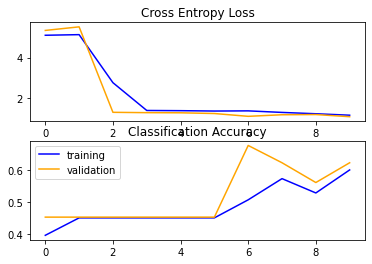

In [ ]:

# Analyze the performance of the baseline by plotting: 
# Report performance measures (accuracy, sensitivity, specificity and F1-score). 
# You can find the hint for plotting multi-class ROC curve here.

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
 
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(4):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 4

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")


Micro-averaged One-vs-Rest ROC AUC score:
0.81
Macro-averaged One-vs-Rest ROC AUC score:
0.64


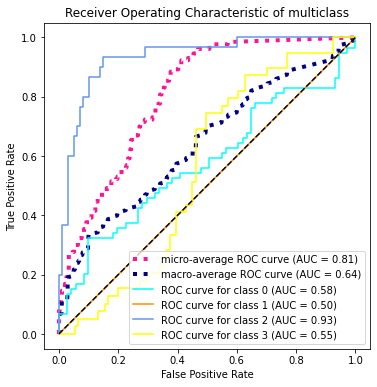

In [ ]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay


fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "yellow"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for class {class_id}",
        color=color,
        ax=ax,
    )

# plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.plot([0, 1], [0, 1], "k--")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic of multiclass")
plt.legend()
plt.show()

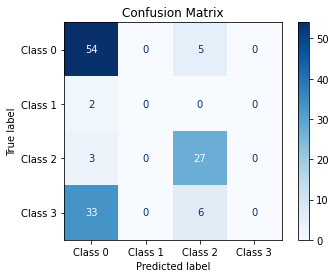

              precision    recall  f1-score   support

           0       0.59      0.92      0.72        59
           1       0.00      0.00      0.00         2
           2       0.71      0.90      0.79        30
           3       0.00      0.00      0.00        39

    accuracy                           0.62       130
   macro avg       0.32      0.45      0.38       130
weighted avg       0.43      0.62      0.51       130



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# Get the predicted classes of the test set
y_pred = np.argmax(y_score, axis=1)

# Get the true classes of the test set
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap using ConfusionMatrixDisplay
display_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3'] # Replace with your own class labels
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Display the plot
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))


In [ ]:

# y_true: true labels of test set
# y_pred: predicted labels of test set

# recall -> sensitivity
# support -> specificity

# Print classification report

# Calculate TN, FP, FN, and TP for each class from the confusion matrix
tn = [cm[i,j] for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j]
fp = [cm[:,j].sum() - cm[j,j] for j in range(cm.shape[1])]
fn = [cm[i,:].sum() - cm[i,i] for i in range(cm.shape[0])]
tp = [cm[i,i] for i in range(cm.shape[0])]

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Extract specificity for each class from the classification report
specificity = {}
for class_name, metrics in report.items():
    if class_name not in ['micro avg', 'macro avg', 'weighted avg', 'accuracy']:
        idx = int(class_name) - 1
        specificity[class_name] = tn[idx] / (tn[idx] + fp[idx])

print("specificity for each class: ",specificity)

specificity for each class:  {'0': 1.0, '1': 0.0, '2': 1.0, '3': 0.0}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Adapting/fine-tuning the network

tuning using grid search for different parameters: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
# turn -> number of layers, batch size, learning rate...

In [ ]:
from keras import models
from keras import layers
from keras import Input
from tensorflow import keras
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(num_layers, activation, loss, X_train, y_train):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape= X_train.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape = X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Add additional convolutional layers based on num_layers parameter
    for i in range(num_layers):
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape= X_train.shape[1:]))
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape = X_train.shape[1:]))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation=activation))

    #The optimizer is Adam
    #the metric should be accuracy and the loss function is expected
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
        
    return model

def run_grid_search(X_train, X_test, y_train, y_test):
    model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0,X_train=X_train, y_train=y_train)
    activation = ['relu', 'sigmoid', 'softmax']
    loss = ['categorical_crossentropy']
    num_layers = [0, 1, 2, 3]  # Number of additional layers to add
    
    param_grid = dict(num_layers=num_layers, activation=activation, loss=loss)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    test_accuracy = grid.score(X_test, y_test)
    print("Test accuracy: %f" % (test_accuracy))
    
    return grid_result


grid_result_turn = run_grid_search(X_train, X_test, y_train, y_test)


<ipython-input-24-7fe1cc88588e>:37: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0,X_train=X_train, y_train=y_train)
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.709302 using {'activation': 'sigmoid', 'loss': 'categorical_crossentropy', 'num_layers': 0}
Test accuracy: 0.638462


In [ ]:
# Train a new model with the best parameters on the full training set
best_params_turn = grid_result_turn.best_params_
best_model_turn = create_model(best_params['activation'], best_params['loss'],X_train=X_train, y_train=y_train)
history_turn = best_model_turn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
y_score_turn = best_model_turn.predict(X_test)

## Turning Performance

### plotting the ROC curve with AUC score

In [ ]:

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_turn.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_turn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(4):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 4

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")


In [ ]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay


fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "yellow"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_score_turn[:, class_id],
        name=f"ROC curve for class {class_id}",
        color=color,
        ax=ax,
    )

# plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.plot([0, 1], [0, 1], "k--")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic of multiclass")
plt.legend()
plt.show()

### reporting performance measures. 


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# Get the predicted classes of the test set
y_pred = np.argmax(y_score_turn, axis=1)

# Get the true classes of the test set
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap using ConfusionMatrixDisplay
display_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3'] # Replace with your own class labels
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Display the plot
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))

In [ ]:

# y_true: true labels of test set
# y_pred: predicted labels of test set

# recall -> sensitivity
# support -> specificity

# Print classification report

# Calculate TN, FP, FN, and TP for each class from the confusion matrix
tn = [cm[i,j] for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j]
fp = [cm[:,j].sum() - cm[j,j] for j in range(cm.shape[1])]
fn = [cm[i,:].sum() - cm[i,i] for i in range(cm.shape[0])]
tp = [cm[i,i] for i in range(cm.shape[0])]

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Extract specificity for each class from the classification report
specificity = {}
for class_name, metrics in report.items():
    if class_name not in ['micro avg', 'macro avg', 'weighted avg', 'accuracy']:
        idx = int(class_name) - 1
        specificity[class_name] = tn[idx] / (tn[idx] + fp[idx])

print("specificity for each class: ",specificity)

Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_augmentation(X_train):
    datagen = ImageDataGenerator(
        rotation_range=20, # rotate the image up to 20 degrees
        width_shift_range=0.1, # shift the image left or right by up to 10%
        height_shift_range=0.1, # shift the image up or down by up to 10%
        horizontal_flip=True, # flip the image horizontally
        vertical_flip=True # flip the image vertically
        shear_range=0.2,  # apply shearing transformations
        zoom_range=0.2,  # zoom in or out on the image
        fill_mode='nearest'  # fill in missing pixels with the nearest value
    )
    datagen.fit(X_train)
    return datagen

# use the fit generator method to train your model with augmented data
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10, validation_data=(X_test, y_test))

# Transfer Learning

# **VGG16** 

In [ ]:
# Loading the vgg16 model
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from keras.models import Model

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    #top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (156, 156, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=4
BATCH_SIZE = 32

n_steps = X_train // BATCH_SIZE
n_val_steps = X_test // BATCH_SIZE
n_epochs = 10

# train the model without Fine-tuning(Freeze the layers)
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
# fit model
history = vgg_model.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=10, verbose=1)
y_score = vgg_model.predict(X_test)

In [ ]:
# Analyze the performance of the baseline by plotting: 
# Report performance measures (accuracy, sensitivity, specificity and F1-score). 
# You can find the hint for plotting multi-class ROC curve here.

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
 
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(4):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 4

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

In [ ]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay


fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "yellow"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for class {class_id}",
        color=color,
        ax=ax,
    )

# plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.plot([0, 1], [0, 1], "k--")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic of multiclass")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# Get the predicted classes of the test set
y_pred = np.argmax(y_score, axis=1)

# Get the true classes of the test set
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap using ConfusionMatrixDisplay
display_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3'] # Replace with your own class labels
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Display the plot
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))